In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import random
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)

2.6.4


In [3]:
BASE_DIR=('../input/typeofpneumonia/type_pneumonia')
train_dir=os.path.join(BASE_DIR,'train/')
val_dir=os.path.join(BASE_DIR,'val/')
test_dir=os.path.join(BASE_DIR,'test/')

print('Number of images in training set = ',str(len(glob(train_dir+'*/*'))))
print('Number of images in validation set = ',str(len(glob(val_dir+'*/*'))))
print('Number of images in testing set = ',str(len(glob(test_dir+'*/*'))))


Number of images in training set =  3859
Number of images in validation set =  16
Number of images in testing set =  398


In [4]:
training_images = tf.io.gfile.glob('../input/typeofpneumonia/type_pneumonia/train/*/*')
validation_images = tf.io.gfile.glob('../input/typeofpneumonia/type_pneumonia/val/*/*')


total_files = training_images
total_files.extend(validation_images)
print(f'Total number of images : training_images + validation_images = {len(total_files)}\n')

#spliting 80:20
train_images, val_images = train_test_split(total_files, test_size = 0.2)
print(f'After division of 80:20')
print(f'Total number of training images = {len(train_images)}')
print(f'Total number of validation images = {len(val_images)}')

Total number of images : training_images + validation_images = 3875

After division of 80:20
Total number of training images = 3100
Total number of validation images = 775


In [5]:
tf.io.gfile.makedirs('/kaggle/working/val_dataset/BACTERIAL/')
tf.io.gfile.makedirs('/kaggle/working/val_dataset/VIRAL/')
tf.io.gfile.makedirs('/kaggle/working/train_dataset/BACTERIAL/')
tf.io.gfile.makedirs('/kaggle/working/train_dataset/VIRAL/')

In [6]:
for ele in train_images:
    parts_of_path = ele.split('/')

    if 'BACTERIAL' == parts_of_path[-2]:
        tf.io.gfile.copy(src = ele, dst = '/kaggle/working/train_dataset/BACTERIAL/' +  parts_of_path[-1])
    else:
        tf.io.gfile.copy(src = ele, dst = '/kaggle/working/train_dataset/VIRAL/' +  parts_of_path[-1])

In [7]:
for ele in val_images:
    parts_of_path = ele.split('/')

    if 'BACTERIAL' == parts_of_path[-2]:
        tf.io.gfile.copy(src = ele, dst = '/kaggle/working/val_dataset/BACTERIAL/' +  parts_of_path[-1])
    else:
        tf.io.gfile.copy(src = ele, dst = '/kaggle/working/val_dataset/VIRAL/' +  parts_of_path[-1])

In [8]:
train_dir='/kaggle/working/train_dataset/'
val_dir='/kaggle/working/val_dataset/'
test_dir='../input/typeofpneumonia/type_pneumonia/test/'

train_bacterial_dir='/kaggle/working/train_dataset/BACTERIAL'
train_viral_dir='/kaggle/working/train_dataset/VIRAL'
val_bacterial_dir='/kaggle/working/val_dataset/BACTERIAL'
val_viral_dir='/kaggle/working/val_dataset/VIRAL'


In [9]:
train_bacterial_fnames=os.listdir(train_bacterial_dir)
train_viral_fnames=os.listdir(train_viral_dir)

print(train_bacterial_fnames[:10])
print(train_viral_fnames[:10])

['person1702_bacteria_4508.jpeg', 'person40_bacteria_203.jpeg', 'person1481_bacteria_3866.jpeg', 'person629_bacteria_2509.jpeg', 'person1463_bacteria_3808.jpeg', 'person1667_bacteria_4418.jpeg', 'person319_bacteria_1475.jpeg', 'person980_bacteria_2906.jpeg', 'person1545_bacteria_4042.jpeg', 'person725_bacteria_2627.jpeg']
['person1540_virus_2680.jpeg', 'person791_virus_1422.jpeg', 'person110_virus_208.jpeg', 'person120_virus_226.jpeg', 'person1161_virus_1948.jpeg', 'person463_virus_952.jpeg', 'person441_virus_896.jpeg', 'person548_virus_1088.jpeg', 'person995_virus_1676.jpeg', 'person1098_virus_1818.jpeg']


In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [11]:
train_datagen=ImageDataGenerator(rescale=1.0/255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.2,
                                 )

val_datagen=ImageDataGenerator(rescale=1.0/255)

test_datagen=ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(train_dir,target_size=(180,180),batch_size=128,class_mode='binary')

val_generator=val_datagen.flow_from_directory(val_dir,target_size=(180,180),batch_size=128,class_mode='binary')

test_generator=test_datagen.flow_from_directory(test_dir,target_size=(180,180),batch_size=128,class_mode='binary')


Found 3100 images belonging to 2 classes.
Found 775 images belonging to 2 classes.
Found 398 images belonging to 2 classes.


In [12]:
pretrained_model3=InceptionV3(input_shape=(180,180,3),
                             include_top=False,
                             weights='imagenet')
#freazing the trained layers
for layers in pretrained_model3.layers:
    layers.trainable=False
    

2022-09-29 02:33:36.947614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 02:33:37.043773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 02:33:37.044659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 02:33:37.046522: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 1s 0us/step


In [13]:
last_layer=pretrained_model3.get_layer('mixed10')
last_output = last_layer.output

In [15]:
x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(1,activation='sigmoid')(x)

model=tf.keras.Model(pretrained_model3.input,x)

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
               metrics=['accuracy','Precision','Recall'])
# model.summary()

In [16]:
history3=model.fit(train_generator,validation_data=val_generator,epochs=30,verbose=2)

2022-09-29 02:34:07.912786: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-09-29 02:34:14.850348: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


25/25 - 58s - loss: 26.6152 - accuracy: 0.5387 - precision: 0.3527 - recall: 0.3941 - val_loss: 0.7247 - val_accuracy: 0.5497 - val_precision: 0.4254 - val_recall: 0.8476
Epoch 2/30
25/25 - 45s - loss: 2.0469 - accuracy: 0.5694 - precision: 0.3734 - recall: 0.3550 - val_loss: 0.8079 - val_accuracy: 0.4632 - val_precision: 0.3828 - val_recall: 0.8922
Epoch 3/30
25/25 - 46s - loss: 1.3691 - accuracy: 0.5952 - precision: 0.4045 - recall: 0.3522 - val_loss: 0.6395 - val_accuracy: 0.6748 - val_precision: 0.5286 - val_recall: 0.5836
Epoch 4/30
25/25 - 45s - loss: 0.7459 - accuracy: 0.6194 - precision: 0.4309 - recall: 0.3011 - val_loss: 0.6574 - val_accuracy: 0.6852 - val_precision: 0.5926 - val_recall: 0.2974
Epoch 5/30
25/25 - 45s - loss: 0.7366 - accuracy: 0.6145 - precision: 0.4253 - recall: 0.3151 - val_loss: 0.6011 - val_accuracy: 0.6645 - val_precision: 0.6552 - val_recall: 0.0706
Epoch 6/30
25/25 - 46s - loss: 0.6930 - accuracy: 0.6497 - precision: 0.4932 - recall: 0.3346 - val_loss:

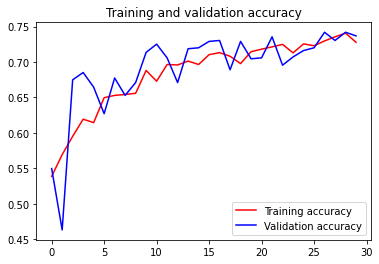

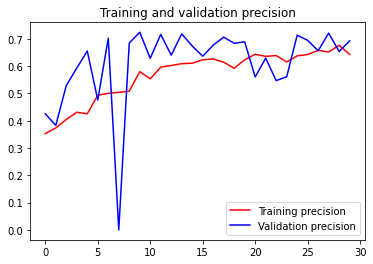

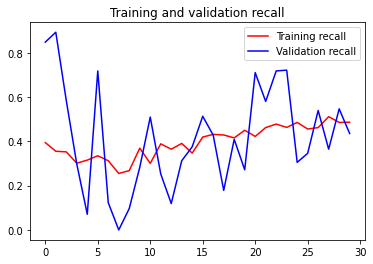

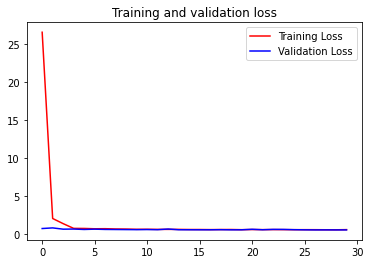

In [17]:
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']

train_precision3=history3.history['precision']
val_precision3=history3.history['val_precision']

train_recall3=history3.history['recall']
val_recall3=history3.history['val_recall']

loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs = range(len(acc3))

plt.plot(epochs, acc3, 'r', label='Training accuracy')
plt.plot(epochs, val_acc3, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, train_precision3, 'r', label='Training precision')
plt.plot(epochs, val_precision3, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.show()

plt.plot(epochs, train_recall3, 'r', label='Training recall')
plt.plot(epochs, val_recall3, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

plt.plot(epochs, loss3, 'r', label='Training Loss')
plt.plot(epochs, val_loss3, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
model.save('bacterialvsviral.h5')


In [20]:
model.evaluate(test_generator)

4/4 [==============================] - 4s 903ms/step - loss: 0.4322 - accuracy: 0.8216 - precision: 0.9326 - recall: 0.5608


[0.4322347939014435, 0.8216080665588379, 0.932584285736084, 0.5608108043670654]